In [10]:
import numpy as np
import scipy
from qutip import *
from numba import jit, njit

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm

from plotly.offline import plot
import plotly.graph_objs as go

from joblib import Parallel, delayed

In [11]:
def spin_operators(N):
    arr_sx = []
    arr_sy = []
    arr_sz = []
    arr_s_ = []
    for n in range(N):
        if n == 0:
            sx_n = 0.5*sigmax() 
            sy_n = 0.5*sigmay() 
            sz_n = 0.5*sigmaz() 
            id_2N = qeye(2)
        elif n > 0:
            sx_n = qeye(2)
            sy_n = qeye(2)
            sz_n = qeye(2)
            id_2N = tensor(id_2N,qeye(2)) 
            
        for m in range(1,n):
            sx_n = tensor( sx_n, qeye(2) )
            sy_n = tensor( sy_n, qeye(2) )
            sz_n = tensor( sz_n, qeye(2) )
        
        if n > 0 :
            sx_n = tensor(sx_n, 0.5*sigmax())
            sy_n = tensor(sy_n, 0.5*sigmay())
            sz_n = tensor(sz_n, 0.5*sigmaz()) 

        for m in range(N-n-1):
            sx_n = tensor( sx_n, qeye(2) )
            sy_n = tensor( sy_n, qeye(2) )
            sz_n = tensor( sz_n, qeye(2) )

        arr_sx.append(sx_n)
        arr_sy.append(sy_n)
        arr_sz.append(sz_n)
        arr_s_.append(sx_n-1j*sy_n)

    return arr_sx, arr_sy, arr_sz, arr_s_, id_2N

In [12]:
gamma_opt0 = 2*np.pi * 0.06    #frequencies in GHz
Delta_opt = 2*np.pi * 0.
kappa_opt = 2*np.pi * 0.0

N = 3
arr_sx, arr_sy, arr_sz, arr_s_, id_N = spin_operators( N )

# Single-qubit down state |0> ≡ |↓>
down = basis(2, 0)
# Tensor product to make |↓↓...↓>
psi0 = tensor([down for _ in range(N)])



e_ops = []
opNtot = id_N*0
for n in range(N):
    sig_n = arr_s_[n]
    opNtot += sig_n.dag()*sig_n
    e_ops.append( sig_n.dag()*sig_n )
e_ops.append( opNtot )


In [13]:
arr_p_click = np.linspace(1e-3,1e-1, 4)
arr_Gamma_plus = gamma_opt0 * np.linspace(1e-3, 10, 4)

arr_P = []
for indx_p, p_click in enumerate(arr_p_click):
    arr_Psup = []
    for indx_G, Gamma_plus in enumerate(arr_Gamma_plus):
        gamma_D = gamma_opt0 * p_click
        gamma_opt = gamma_opt0

        H0 = id_N*0
        c_unr = id_N*0
        c_jumps = []
        for n in range(N):
            sig_n = arr_s_[n]
            H0 += Delta_opt*sig_n.dag()*sig_n 
            
            c_unr += np.sqrt(gamma_D*N)*arr_s_[n]/np.sqrt(N)
            
            c_jumps.append( np.sqrt(gamma_opt)*sig_n )
            c_jumps.append( np.sqrt(Gamma_plus)*sig_n.dag() )
            c_jumps.append( np.sqrt(kappa_opt)*sig_n.dag()*sig_n )

        c_jumps.append( c_unr )

        Hin = H0


        Ntraj = 1000
        Ntimes = 500
        tlist = np.linspace(0, 300, Ntimes)  # in ns
        options = Options(atol=1e-7, norm_t_tol=1e-7, norm_tol=1e-5)

        # Define a function for the computation of a single trajectory
        def compute_trajectory(ntraj):
            sol = mcsolve(Hin, psi0, tlist, c_jumps, [], ntraj=1, options=options)
            psi_t = sol.states
            psi_ss = psi_t[Ntimes - 1]
            rho_ss = psi_ss * psi_ss.dag()
            Sq = entropy_vn(rho_ss.ptrace(0))
            Ntot = np.abs(expect(opNtot, psi_ss))
            return Sq, Ntot

        # Use joblib to parallelize the loop
        results = Parallel(n_jobs=5)(
            delayed(compute_trajectory)(ntraj) for ntraj in range(Ntraj)
        )

        # Aggregate the results
        arr_Sq, arr_Ntot = zip(*results)
        arr_Sq = list(arr_Sq)
        arr_Ntot = list(arr_Ntot)

        arr_Sq = np.asarray(arr_Sq)

        prob = np.sum(arr_Sq > 0.5) / arr_Sq.size
        arr_Psup.append(prob)
    arr_P.append(arr_Psup)
    
arr_P = np.asarray(arr_P)

 

100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.01s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.01s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.01s
Total run time:   0.01s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.01s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.01s
Total run time:   0.02s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.01s
Total run time:   0.01s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.01s
100.0%. Run time:   0.00s. Est. time left: 00

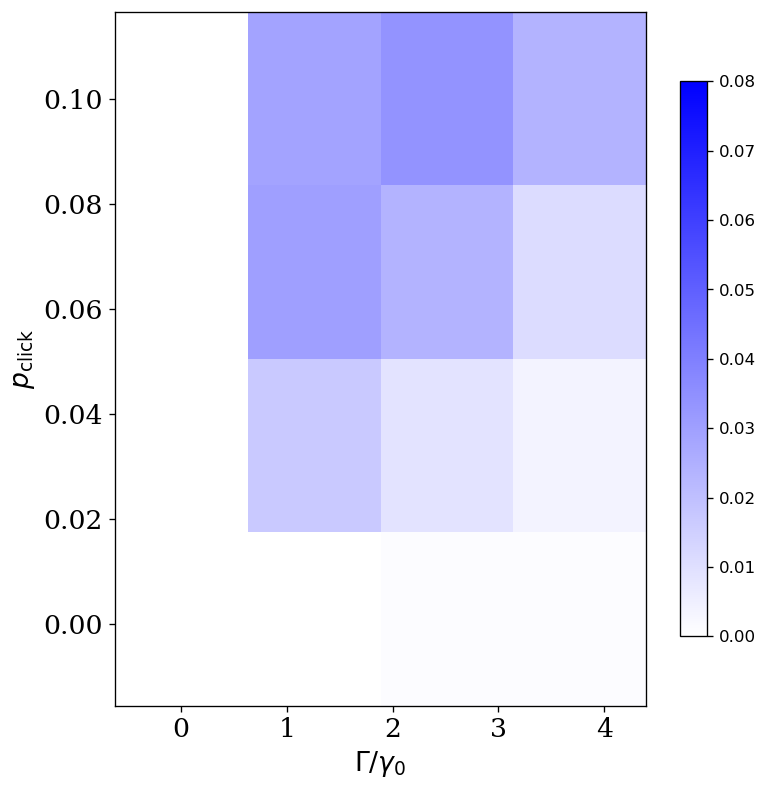

In [15]:
from matplotlib.colors import Normalize
from matplotlib.animation import FuncAnimation
from matplotlib import cm
from IPython.display import HTML

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

# Initialize figure for Wigner function animation
fig_w, ax_w = plt.subplots(dpi=120, figsize=(5, 5))
X, Y = np.meshgrid(arr_Gamma_plus, arr_p_click)
# Normalize the colormap around 0
custom_cmap = LinearSegmentedColormap.from_list('white_to_blue', [(1, 1, 1), (0, 0, 1)])  # White to Blue
norm = Normalize(vmin=0, vmax=.08 )
# Create the pcolormesh plot
wigner_plot = ax_w.pcolormesh(X, Y, arr_P, cmap=custom_cmap, shading='auto', norm=norm)
# Add the color bar
cbar = fig_w.colorbar(wigner_plot, ax=ax_w, orientation='vertical', shrink=0.8)
# Set labels and aspect ratio
ax_w.set_xlabel(r'$\Gamma/\gamma_0$',fontdict=font)
ax_w.set_ylabel(r'$p_{\rm click}$', fontdict=font)
#ax_w.set_aspect('equal')
plt.xticks(fontsize=font['size'], fontname=font['family'], weight=font['weight'], color=font['color'])
plt.yticks(fontsize=font['size'], fontname=font['family'], weight=font['weight'], color=font['color'])
#plt.grid()
plt.gcf().set_size_inches(170 / 25.4, 170 / 25.4)
plt.tight_layout()